<a href="https://colab.research.google.com/github/AG-2002/Dynamic-Pricing-for-Urban-Parking-Lots/blob/main/Model_2_Demand_Based_Price_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

In [3]:
df=pd.read_csv('Dataset.csv')
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


# **Model 2 : Demand-Based Price Function**

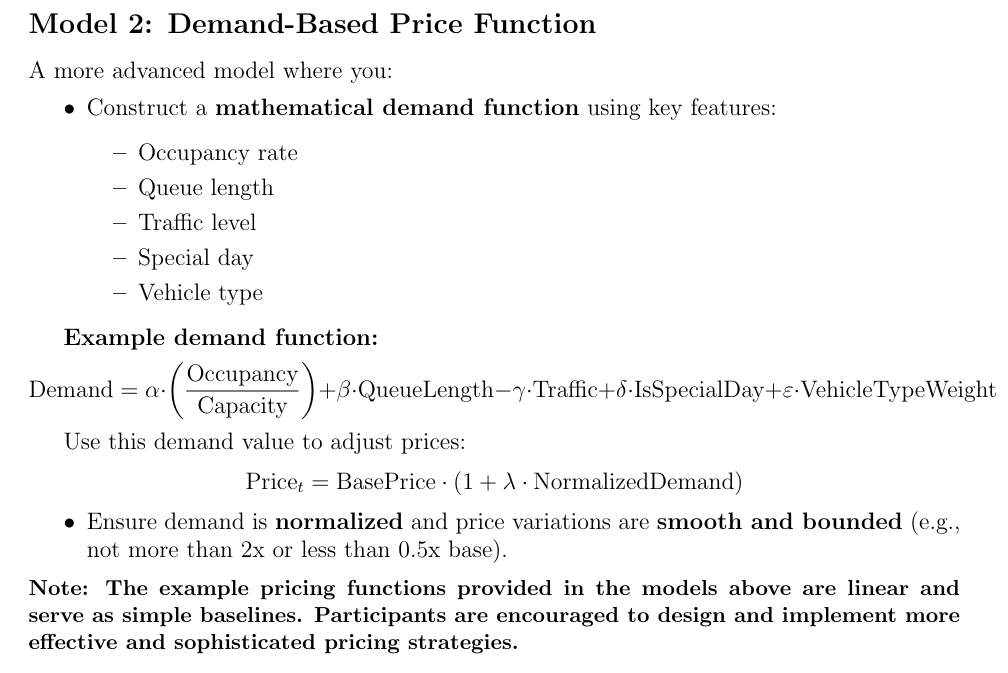

In [4]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [5]:
# Fill any missing values
df = df.fillna(0)

# Assign vehicle type weights
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5
}

TrafficConditionNearby_weights={
    'low': 0.5,
    'average': 1.0,
    'high': 1.5
}

df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights).fillna(1.0)  # Default weight = 1.0
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map(TrafficConditionNearby_weights).fillna(1.0)  # Default weight = 1.0

# Safety check
df['Capacity'] = df['Capacity'].replace(0, np.nan)  # avoid div-by-zero

In [6]:
# Coefficients
α = 2.0     # Occupancy weight
β = 0.5     # Queue length weight
γ = 1.0     # Traffic penalty
δ = 2.0     # Special day bonus
ε = 1.5     # Vehicle type weight
λ = 0.8     # Price sensitivity

# Compute demand score
df['Utilization'] = df['Occupancy'] / df['Capacity']
df['DemandScore'] = (
    α * df['Utilization'] +
    β * df['QueueLength'] -
    γ * df['TrafficConditionNearby'] +
    δ * df['IsSpecialDay'] +
    ε * df['VehicleWeight']
)

In [7]:
# Normalize demand to [0, 1]
min_demand = df['DemandScore'].min()
max_demand = df['DemandScore'].max()

df['NormalizedDemand'] = (df['DemandScore'] - min_demand) / (max_demand - min_demand)


In [10]:
BASE_PRICE = 10

df['Model2_Price'] = BASE_PRICE * (1 + λ * df['NormalizedDemand'])

# Clip to price bounds
df['Model2_Price'] = df['Model2_Price'].clip(lower=5, upper=20)

# Preview
df[['SystemCodeNumber', 'Timestamp', 'Occupancy','Capacity','QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Model2_Price']].to_csv("Demand-Based_Price_Function_Price.csv", index=False)


In [11]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,VehicleWeight,Utilization,DemandScore,NormalizedDemand,Model2_Price
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,0.5,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,0.105719,1.711438,0.129511,11.036088
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,0.5,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0.5,0.197500,1.645000,0.123466,10.987725
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,0.5,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,0.384279,2.768559,0.225701,11.805611
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,0.5,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,0.513402,3.026804,0.249200,11.993599
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,0.5,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,0.319792,2.639583,0.213966,11.711724


In [34]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    SystemCodeNumber: str  # Unique identifier for the parking location
    Timestamp: str   # Timestamp of the observation (should ideally be in ISO format)
    Occupancy: int   # Number of occupied parking spots
    Capacity: int    # Total parking capacity at the location
    QueueLength: int # Current length of the parking queue
    Latitude: float  # Latitude coordinate of the parking location
    Longitude: float # Longitude coordinate of the parking location

In [35]:
data = pw.demo.replay_csv("Demand-Based_Price_Function_Price.csv", schema=ParkingSchema, input_rate=1000)

In [40]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


In [41]:
import datetime

BASE_PRICE = 10.0
ALPHA = 5.0  # Adjust this to control sensitivity

delta_window = (
    data_with_time.windowby(
        pw.this.t,                         # Event time column
        instance=pw.this.day,              # Partition per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # Daily window
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,
        occ_sum=pw.reducers.sum(pw.this.Occupancy),
        cap_sum=pw.reducers.sum(pw.this.Capacity),
        count=pw.reducers.count()
    )
    .with_columns(
        occ_avg=pw.this.occ_sum / pw.this.count,
        cap_avg=pw.this.cap_sum / pw.this.count
    )
    .with_columns(
        price=BASE_PRICE + ALPHA * (pw.this.occ_avg / pw.this.cap_avg)
    )
)

In [42]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "BASE_PRICE", source=source, line_width=2, color="navy")

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "BASE_PRICE", source=source, size=6, color="red")

    return fig

# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = delta_window.plot(price_plotter, sorting_col="t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [45]:
# Start the Pathway pipeline execution in the background
# - This triggers the real-time data stream processing defined above
# - %%capture --no-display suppresses output in the notebook interface

%%capture --no-display
pw.run()